In [14]:
import pandas as pd
import numpy as np
import scipy.signal
import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import math

In [28]:
path = "datos"
load_path = path + "/{}.hdf"
electrodos = [8, 44, 80, 131, 185]

N_P = 10
N_S = 10
pacientes_P = []
pacientes_S = []
for load_name, N, dest, offset in [("P", N_P, pacientes_P, 0), ("S", N_S, pacientes_S, 10)]:
    for i in range(1, 1 + N):
        paciente = load_name + "{:02d}".format(i)
        df_ = pd.read_hdf(load_path.format(paciente))
        df_ = df_.loc[offset + i-1,:,electrodos,:]
        dest.append(df_)

a1

In [30]:
pacientes_S[0].head()

valores
paciente epoch sensor tiempo              
10       0     8      0       2.123794e-06
                      1      -1.335104e-06
                      2      -3.321541e-06
                      3      -1.837935e-06
                      4       2.672972e-07

In [31]:
dfs1 = [pacientes_P[i].loc[i,:,[8,44,80,131,185],:] for i in range(N_P)] + \
    [pacientes_S[i].loc[i + 10,:,[8,44,80,131,185],:] for i in range(N_S)]

In [32]:
sensor_means = [df.groupby(['epoch', 'tiempo']).mean() for df in dfs1]

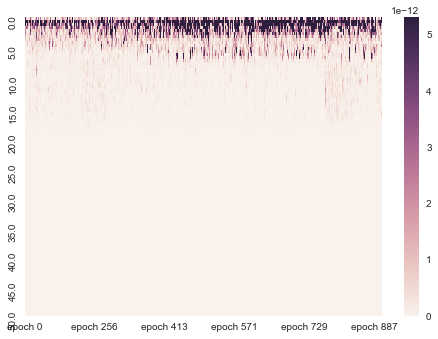

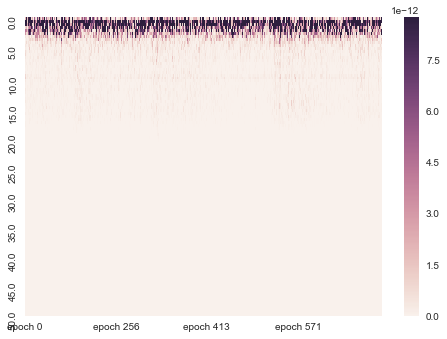

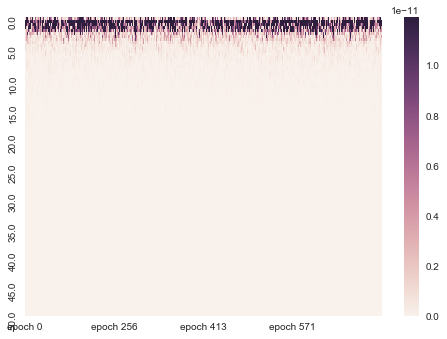

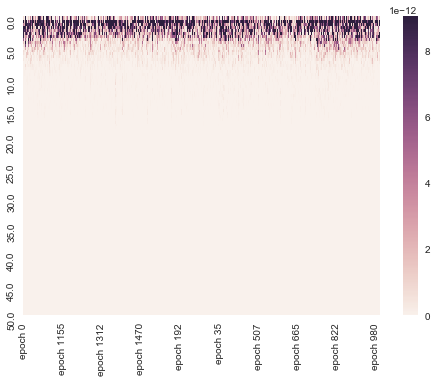

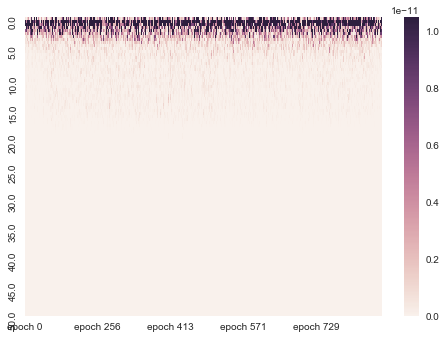

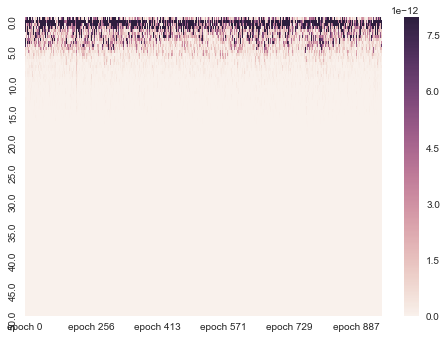

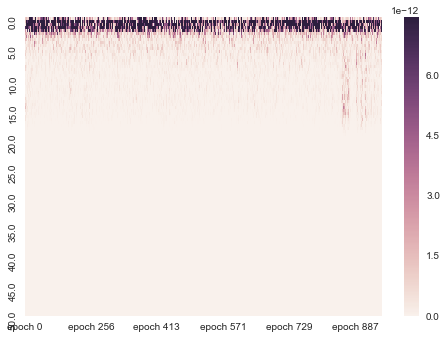

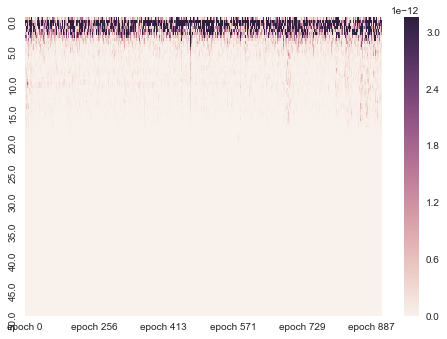

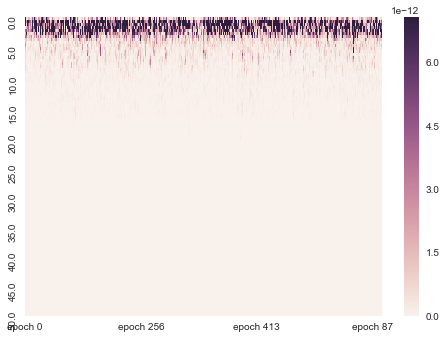

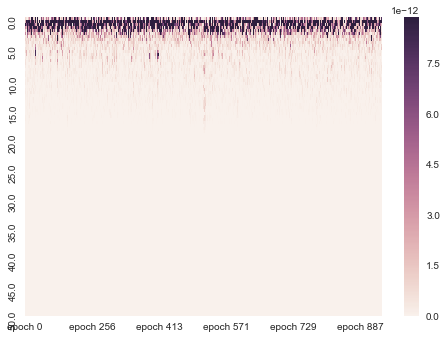

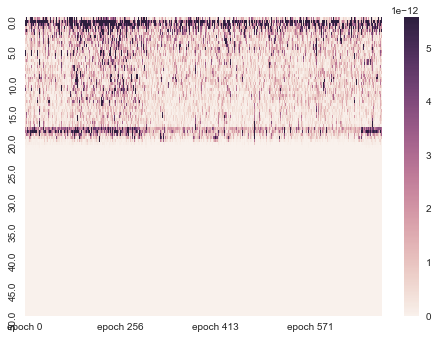

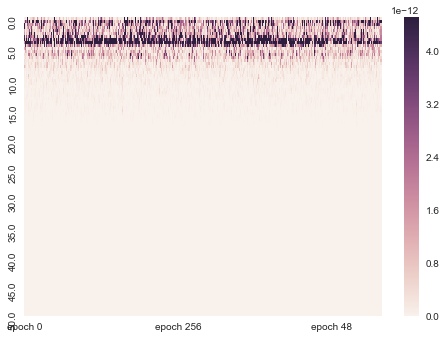

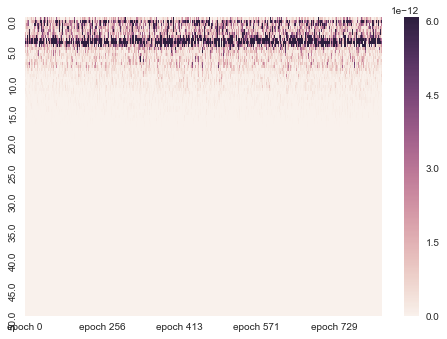

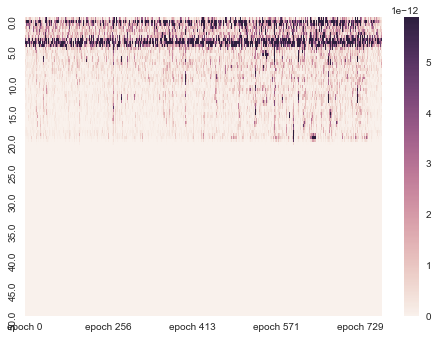

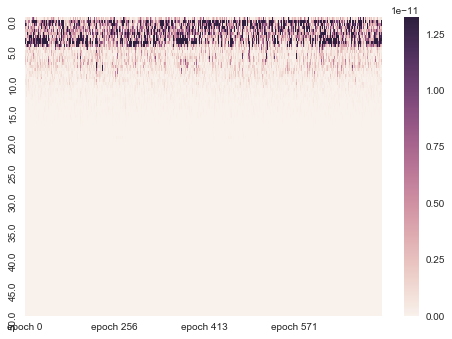

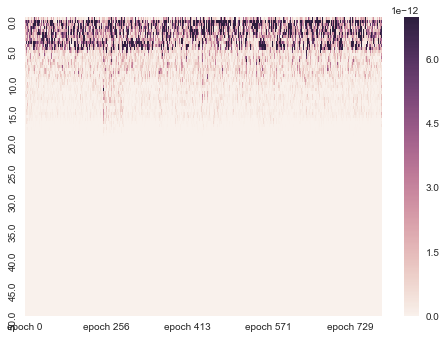

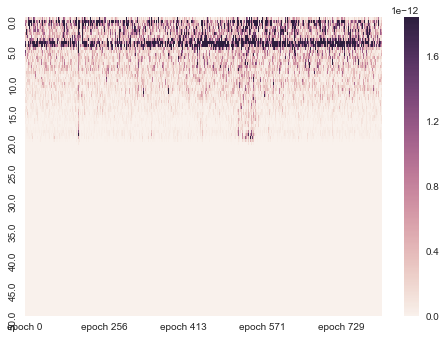

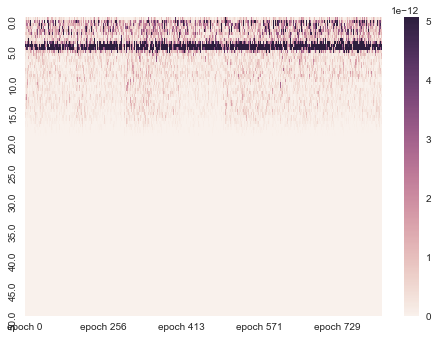

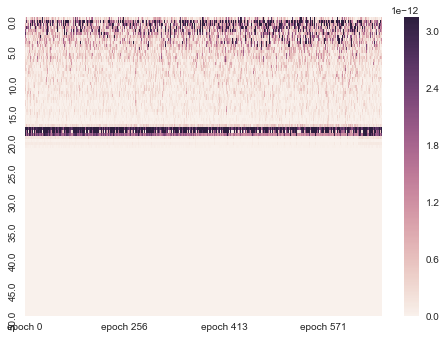

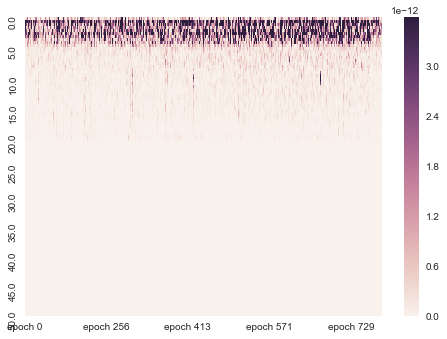

In [33]:
for sm in sensor_means:
    frecuencias = sm.groupby(['epoch']).apply(lambda x: scipy.signal.welch(x['valores'], fs=250, nperseg = 250))
    data = {'epoch {}'.format(i): f for i,f in enumerate(map(lambda x: x[1], frecuencias.values))}
    index = frecuencias.values[0][0]
    f_df = pd.DataFrame(data=data, index=index)
    
    g = sns.heatmap(f_df, xticklabels=175, yticklabels=10, robust=True)
    sns.plt.show()


a2

In [20]:
epoch_means = [df.groupby(['sensor', 'tiempo']).mean() for df in pacientes_P]

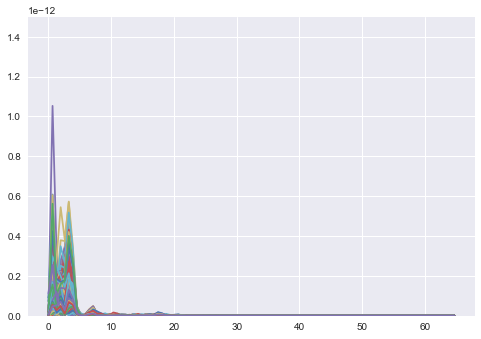

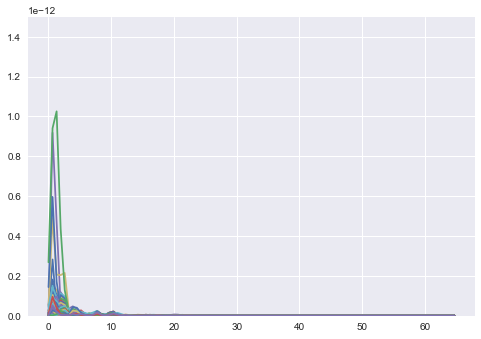

In [21]:
for em in epoch_means:
    for sensor, df_g in em.groupby(['sensor']):
        f, P = scipy.signal.welch(df_g['valores'].values, fs=130, nperseg=201)
        sns.plt.plot(f, P)
    axes = sns.plt.gca()
    axes.set_ylim([0,1.5*10**-12])
    sns.plt.show()

b <b>No entiendo porque los valores de f quedan entre 0 y 0.5 en lugar de quedar entre 0 y 50</b>

In [22]:
def calcular_frecuencias(f, P):
    return {
        'delta': P[f<4].sum(),
        'theta': P[(4<=f) & (f<8)].sum(),
        'alpha': P[(8<=f) & (f<13)].sum(),
        'beta': P[(13<=f) & (f<30)].sum(),
        'gamma': P[30<=f].sum()
    }
    

bandas_P = []
bandas_S = []
for bandas, pacientes in [(bandas_P, pacientes_P), (bandas_S, pacientes_S)]:
    for i, p in enumerate(pacientes):
        frecuencia_media = p.groupby(['tiempo']).mean()
        f, P = scipy.signal.welch(frecuencia_media['valores'], fs=130, nperseg=201)
        bandas.append(calcular_frecuencias(f,P))



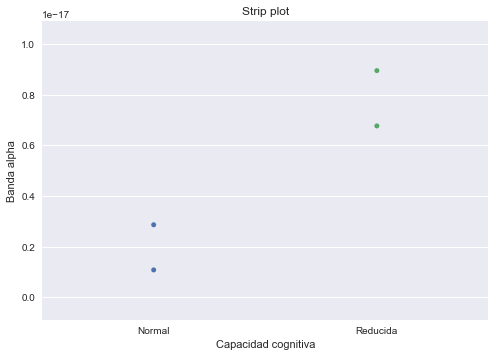

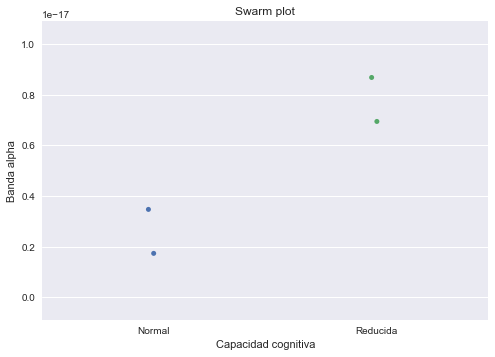

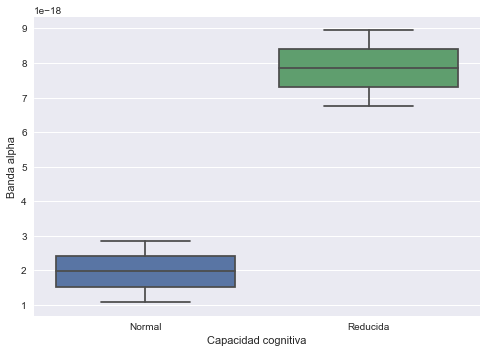

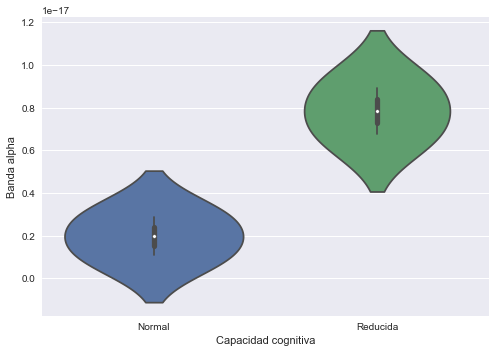

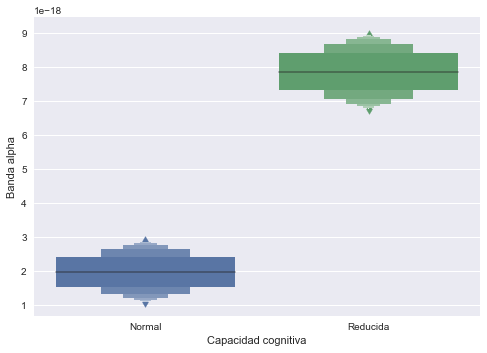

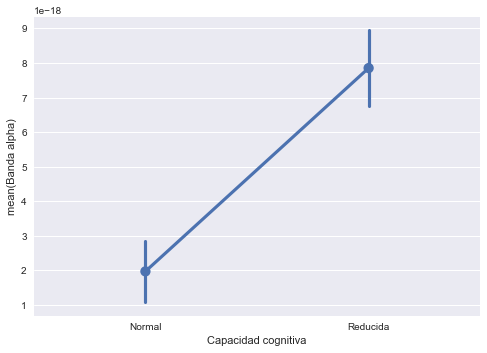

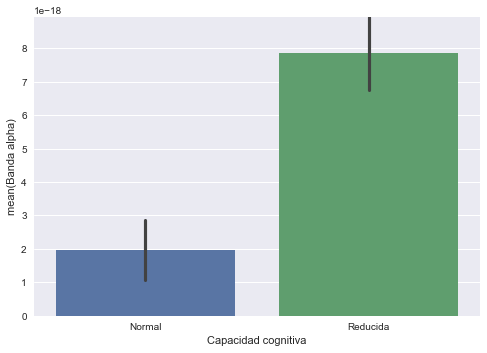

In [23]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Normal"] * N_S) + (["Reducida"] * N_P),
    "Banda delta": [d['delta'] for d in bandas_S + bandas_P],
    "Banda theta": [d['theta'] for d in bandas_S + bandas_P],
    "Banda alpha": [d['alpha'] for d in bandas_S + bandas_P],
    "Banda beta": [d['beta'] for d in bandas_S + bandas_P],
    "Banda gamma": [d['gamma'] for d in bandas_S + bandas_P],
})

ymin = min(df_bandas['Banda alpha'])
ymax = max(df_bandas['Banda alpha'])
decimo = (ymax - ymin)/len(df_bandas['Banda alpha'])
ymin, ymax = ymin - decimo, ymax + decimo

ax = sns.stripplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_ylim([ymin, ymax])
ax.set_title("Strip plot")
sns.plt.show()

ax = sns.swarmplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_ylim([ymin, ymax])
ax.set_title("Swarm plot")
sns.plt.show()

sns.boxplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Box plot")
sns.plt.show()

sns.violinplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Violin plot")
sns.plt.show()

sns.lvplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Lette value plot")
sns.plt.show()

sns.pointplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Point plot")
sns.plt.show()

sns.barplot(x="Capacidad cognitiva", y="Banda alpha", data=df_bandas)
ax.set_title("Bar plot")
sns.plt.show()



Se decide utilizar una combinación de violinplot y de swarmplot. El primero permite entender la distribución de los elementos, mientras que con el segundo se ven los valores puntuales.

In [24]:
def calcular_delta(d,e):
    mean_1_inicial = d[e == e[0]].mean()
    mean_2_inicial = d[e != e[0]].mean()
    return mean_2_inicial - mean_1_inicial


def permutation_test(d,e, n=100):
    d0 = calcular_delta(d, e)
    deltas = np.zeros(n)
    aux_e = e.copy()

    for i in range(n):
        np.random.shuffle(aux_e)
        deltas[i] = calcular_delta(d,aux_e)

    return deltas, d0

def foo(a, e_a, b, e_b):
    e_1 = np.full(a.shape[0], e_a) 
    e_2 = np.full(b.shape[0], e_b)
    e = np.concatenate((e_1, e_2)) 
    d = np.concatenate((a,b))
    return d,e

def test_permutacion(soleado, lluvioso):
    d, e = foo(soleado, 's', lluvioso, 'l')

    # delta-value : la diferencia entre las medias que presenta nuestra información 
    # p-value es la probabilidad de haber obtenido este delta o mayor

    deltas, delta_value = permutation_test(d,e)
    p_value = deltas[deltas >= delta_value].shape[0]/deltas.shape[0]

    return p_value
    #printnt("Delta-value = {} | p-value = {}".format(delta_value, p_value))

    # Delta-level : el delta que atrapa el percentil 1-'alpha-level' de la distribución
    # Nuestro Delta-value debería caer antes de a esto para no rechazar H0
    delta_level = np.percentile(deltas, 95)

    fig = sns.plt.figure(dpi=100)
    sns.plt.axes().set_title('Test de Permutaciones', fontsize=20)
    sns.plt.axes().set_xlabel('Delta', fontsize=14) 
    sns.plt.axes().set_ylabel('# Repeticiones', fontsize=14) 

    sns.distplot(deltas, norm_hist=False, kde=False)
    sns.plt.axvline(x=delta_value, linewidth=1, color='red', linestyle="dotted", label="d-value")
    sns.plt.axvline(x=delta_level, linewidth=1, color='g', linestyle="dotted", label="d-level")
    
    sns.plt.legend()

    #Cuadro para printear valores
    textstr = "d-value : {} \n p-value : {} \n d-level : {}".format(round(delta_value,3),round(p_value,3),round(delta_level,3))
    props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)
    sns.plt.axes().text(0.97, 0.5, textstr, fontsize=10,verticalalignment='center', bbox=props)

    sns.plt.show()
    

def analisis_comparativo(df_b):
    ymin = min(df_b['Potencia'])
    ymax = max(df_b['Potencia'])
    decimo = (ymax - ymin)/len(df_b['Potencia'])
    ymin, ymax = ymin - decimo, ymax + decimo

    # Despues veo con cual quedarme
    # Hay que tener en cuenta que son pocos valores

    sns.violinplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2", inner="stick", cut=0)
    sns.plt.show()


    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b,  split=True, palette="Set2")
    ax.set_ylim([ymin, ymax])
    sns.plt.show()


    sns.barplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", data=df_b, palette="Set2")
    ax = sns.swarmplot(x="Banda", y="Potencia", hue="Capacidad cognitiva", split=True, data=df_b)
    ax.set_ylim([ymin, ymax])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2])
    sns.plt.show()
    
    print("Probabilidad de que tengan la misma media ambos grupos para:")
    p_values = {}            
    for banda in ["delta", "theta", "alpha", "beta", "gamma"]:
        p_values[banda] = \
            test_permutacion(df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Reducida")]['Potencia'],
                             df_b[(df_b['Banda'] == banda) & (df_b['Capacidad cognitiva'] == "Normal")]['Potencia'])
        print("\t- para la banda {}: {}".format(banda, p_values[banda]))
        
def normalizar_banda(df_):
    min_pot = min(df_['Potencia'])
    max_pot = max(df_['Potencia'])
    
    df_["Potencia"] = (df_["Potencia"] - min_pot) / (max_pot - min_pot)
    
    return df_
    

In [25]:
df_bandas = pd.DataFrame({
    "Capacidad cognitiva": (["Reducida"] * (N_P * 5)) + (["Normal"] * (N_S * 5)),
    "Banda": list(itertools.chain(*[list(d.keys()) for d in bandas_P + bandas_S])),
    "Potencia": list(itertools.chain(*[list(d.values()) for d in bandas_P + bandas_S]))
})
df_bandas_normalizadas = df_bandas.groupby(['Banda']).apply(normalizar_banda)


Análisis comparativo para las distintas bandas:


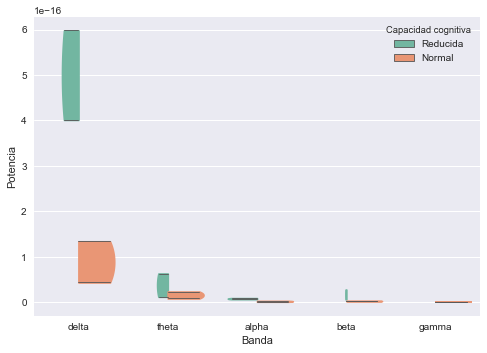

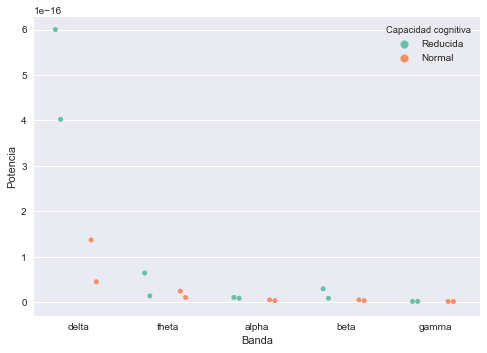

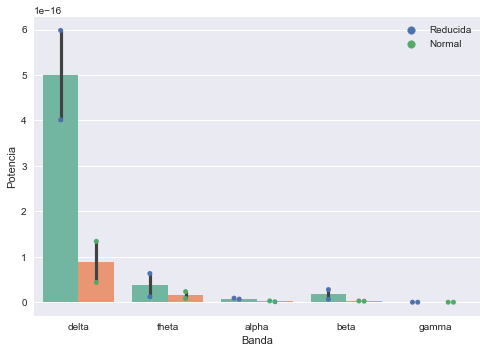

Probabilidad de que tengan la misma media ambos grupos para:
	- para la banda delta: 1.0
	- para la banda theta: 0.69
	- para la banda alpha: 1.0
	- para la banda beta: 1.0
	- para la banda gamma: 1.0
------------
Análisis comparativo normalizado para las distintas bandas:


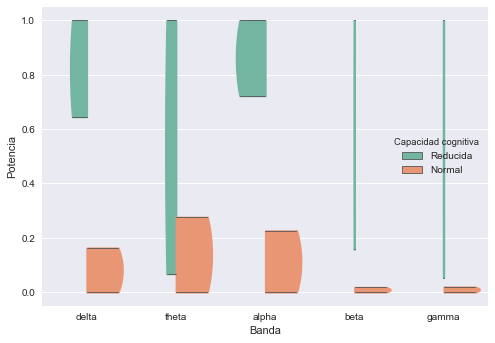

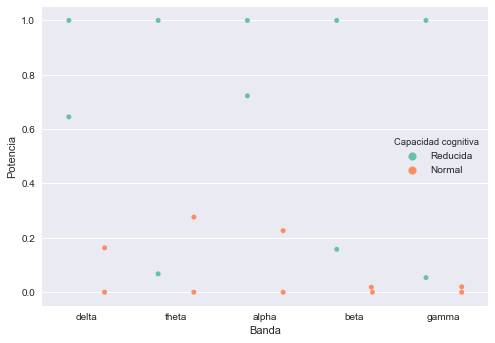

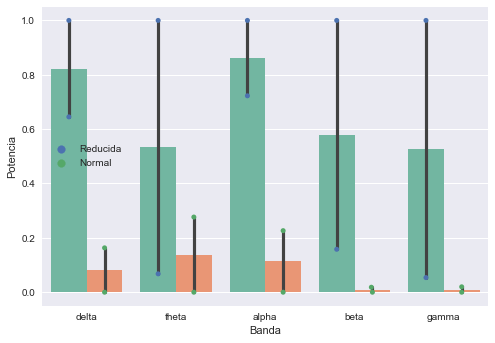

Probabilidad de que tengan la misma media ambos grupos para:
	- para la banda delta: 1.0
	- para la banda theta: 0.69
	- para la banda alpha: 1.0
	- para la banda beta: 1.0
	- para la banda gamma: 1.0


In [26]:
print("Análisis comparativo para las distintas bandas:")
analisis_comparativo(df_bandas)
print("------------", "Análisis comparativo normalizado para las distintas bandas:", sep="\n")
analisis_comparativo(df_bandas_normalizadas)

